In [1]:
#!pip install transformers==4.12.0
#!pip install tensorflow==2.4.0
#!pip install datasets
#!pip install wandb
#!pip install langdetect

In [330]:
first_run = False

In [331]:
import pandas as pd
import json
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
#from google.colab import drive
from langdetect import detect
import matplotlib.dates as md

%load_ext autoreload
%autoreload 2

#drive.mount('/content/drive/')
#%cd '/content/drive/My Drive/eu_commission'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read in the data

In [1519]:
fs = glob.glob('data/*/*')
fields = ['text', 'lang']
metrics = [f'{m}_count' 
           for m in ['like','quote','reply','retweet']]
processed_tws = []
for f in fs:
    tws = json.load(open(f))['data']
    for i in range(len(tws)):
        item = {k: tws[i][k] for k in fields}
        item.update({k: tws[i]['public_metrics'][k] for k in metrics})
        item.update({'created_at': tws[i]['created_at'][:10]})
        tws[i] = item
    processed_tws += tws

In [1520]:
df = pd.DataFrame(processed_tws)
df['created_at'] = pd.to_datetime(df['created_at'], infer_datetime_format=True)

### Tweet volume

In [319]:
freq_dict = {'D': 'day', 'W': 'week', 'M': 'month'}
figsizes = {'D': (50,5), 'W': (50,5), 'M': (30, 5)}
formats = {'D': '%Y-%m-%d', 'W': '%Y-%m-%d', 'M': '%Y-%m'}

def plot_volume(language='en', freqs='D', plot_smooth_only=False, roll_window=7):
    top_dict = {}
    for freq in [freqs]:
        fig, ax = plt.subplots(figsize=figsizes[freq])
        if df['created_at'].dtype != 'datetime64':
            df['created_at'] = pd.to_datetime(df['created_at'], infer_datetime_format=True)
        if language=='all':
            grouped = df.groupby(pd.Grouper(key='created_at', axis=0, freq=freq)).count().reset_index()      
        elif language=='en':
            grouped = df.groupby(pd.Grouper(key='created_at', axis=0, freq=freq)).count().reset_index()
        else:
            new_df = df.copy()
            new_df['is_other'] = np.where((new_df['lang']=='en') & (new_df['lang_detected']=='en'), 0, 1)
            counts = new_df.groupby(grouper).count().reset_index()[['created_at','text']].rename({'text': 'count'}, axis=1)
            by_lang = new_df.groupby([grouper,'is_other']).count().reset_index() 
            grouped = pd.merge(by_lang, counts, how='outer')
            grouped['text'] = np.where(grouped['count'] != 0, grouped['text'] / grouped['count'], 0)
            grouped = grouped[grouped['is_other']==1]
            grouped = grouped.fillna(0)
        top_dict[freq_dict[freq]] = grouped.sort_values(by='text', ascending=False).head(n=5)[['created_at', 'text']].to_records(index=False)
        grouped['smoothed'] = grouped['text'].rolling(roll_window).mean()
        # Plot 
        if not plot_smooth_only:
            sns.lineplot(data=grouped, x='created_at', y='text', 
                         alpha=.2, 
                         label='per day')
        sns.lineplot(data=grouped, x='created_at', y='smoothed', 
                     label=f'smoothed avg - {roll_window}d', 
                     color=sns.color_palette()[0])
        if language in ['all', 'en']:
            plt.ylabel(f'Tweets per {freq_dict[freq]}')
            plt.xlabel('')
            plt.title(f'Tweet volume {language.upper()}')
        else:
            plt.ylabel(f'Proportion tweets per {freq_dict[freq]}')
            plt.xlabel('')
            plt.title(f'Proportion tweets not in English')
        plt.xticks(rotation=60)
        # Make year boundaries
        for d in grouped.created_at.dt.year.unique()[1:]:
            plt.axvline(x=np.datetime64(f'{d}-01-01'), color='darkgrey', linestyle='--')
            plt.annotate(text=d, xy=(np.datetime64(f'{d}-06-01'),120), color='black')
        ax.xaxis.set_major_locator(md.MonthLocator())
        ax.xaxis.set_major_formatter(md.DateFormatter('%b \'%y'))
        plt.xlim(np.datetime64('2010-05-01'),np.datetime64('2022-08-01'))
        if language == 'en':
            plt.savefig(f'figures/tweet_volume_EN.pdf')
        else:
            plt.savefig(f'figures/tweet_volume_others.pdf')
        plt.show()
    return top_dict

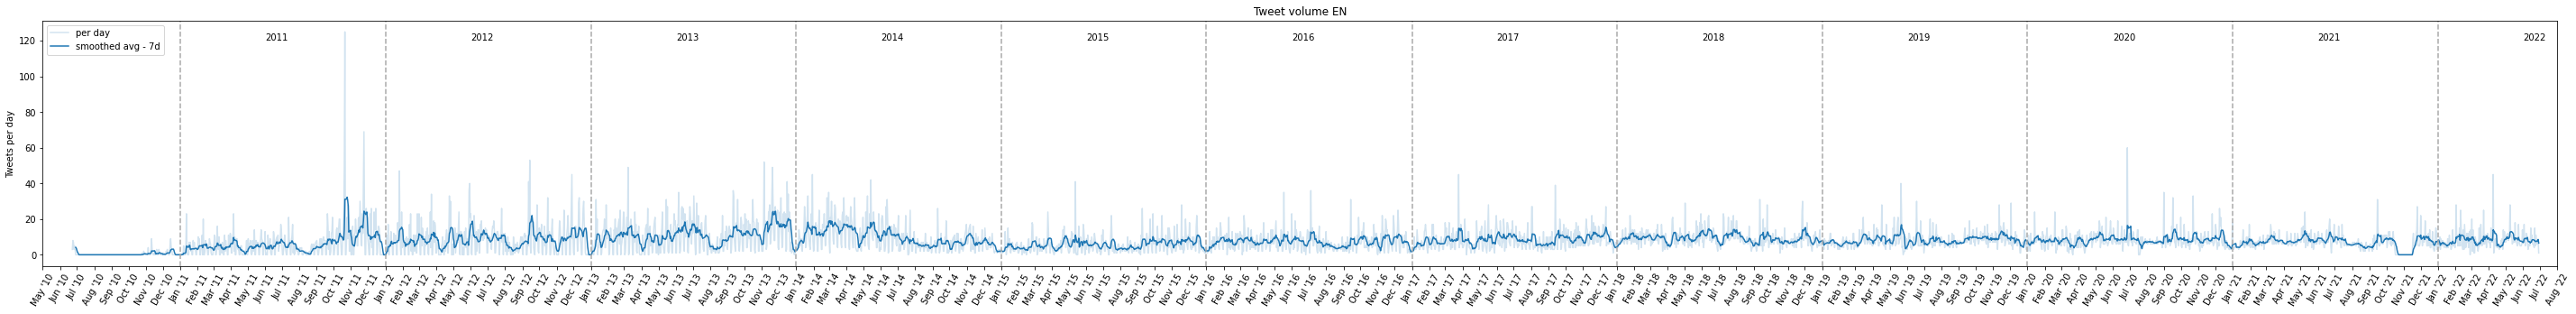

In [320]:
top_dict = plot_volume(roll_window=7)

In [321]:
print(df[df.created_at == np.datetime64(top_dict['day'][1][0])].text.tolist())
print(top_dict['day'][1][0])

['Air transport: #EC requests Austria, Germany, Italy and Luxembourg to comply with rules on airport charges  http://t.co/sVQ7iwfQ', 'Maritime safety:#EC requests #Italy to comply with new safety rules for passenger ships http://t.co/hMqNwrO7', 'Rail: #EC refers #Germany to Court of Justice over railway safety http://t.co/0Nfo9eAp', '#EC asks the #United Kingdom to pay due amounts of customs duties to #EU budget  http://t.co/qsjObEPR', 'Free movement of goods: #EC requests #Greece to facilitate the selling of "bake off" products  http://t.co/qH6GSk8m', 'Free movement of goods: #EC requests #Netherlands to comply with EU rules on firearms  http://t.co/3KCimGLY', "Working time: #EC requests #Belgium to end compulsory postponement of workers' annual leave http://t.co/U9GlQkPC", 'Free movement of workers: #EC requests #Italy to end discrimination in recruiting university professors  http://t.co/PFJGDfLI', 'Social Security: #EC requests #Spain to end refusal of European Health Insurance Car

Some of the peaks with highest volumes are related to live tweeting of #EUMFF negotiations, automated posting re: to activity on other websites (Storify), and other. 
Worth keeping in mind that tweet volume can be a major confounder with this data.

### Additional preprocessing
- flag retweets and tweets starting with mentions;
- strip links;
- not removing emojis, hashtags and mentions, for now - but could remove depending on which model we end up using;
- assign some tweet to a "pretraining" dataset

Re: this latter. Let's leave out a small dataset for pretraining of our language models. We pick a random set of tweets (if that does not show good results, we could consider balanced sampling over time).

In [322]:
def language_detection(s):
    try:
        return detect(s)
    except:
        return 'unk'

In [323]:
if first_run is True:
    
    # Preprocessing
    df['is_retweet'] = np.where(df['text'].str.startswith('RT'), 1, 0)
    df['is_mention'] = np.where(df['text'].str.startswith('@'), 1, 0)
    df['text'] = df['text'].str.replace(r'http.*', '', regex=True)
    df = df[df['text'].str.len() > 0]
    df['lang_detected'] = df['text'].apply(language_detection)
    df[df['lang']!=df['lang_detected']]
    
    # Pretraining splits
    import random
    random.seed(42)
    train_size = 3000
    val_size = 500
    train_test = ['train'] * train_size + ['val'] * val_size + ['test'] * (df.shape[0] - train_size - val_size)
    random.shuffle(train_test)
    df['pretraining_splits'] = train_test
    
    # Save
    df.to_json('processed/all_tweets.jsonl', lines=True, orient='records')

Breakdown of number of tweets per language

In [1522]:
df = pd.read_json('processed/all_tweets.jsonl', lines=True, orient='records')
print(df.groupby('lang')['text'].count().reset_index().sort_values(by='text', ascending=False).rename({'text': 'count'}, axis=1))

   lang  count
7    en  32446
12   fr    828
5    de    207
8    es    155
29  und    122
17   it     81
24   ro     69
28   uk     47
22   pl     45
20   nl     37
23   pt     36
1    ca     33
6    el     29
4    da     28
9    et     23
11   fi     22
2    cs     21
26   sv     19
0    bg     16
15   in     12
19   lv     10
18   lt     10
25   sl     10
14   hu      9
27   tl      5
3    cy      4
13   ht      2
10   eu      2
21   no      1
16   is      1


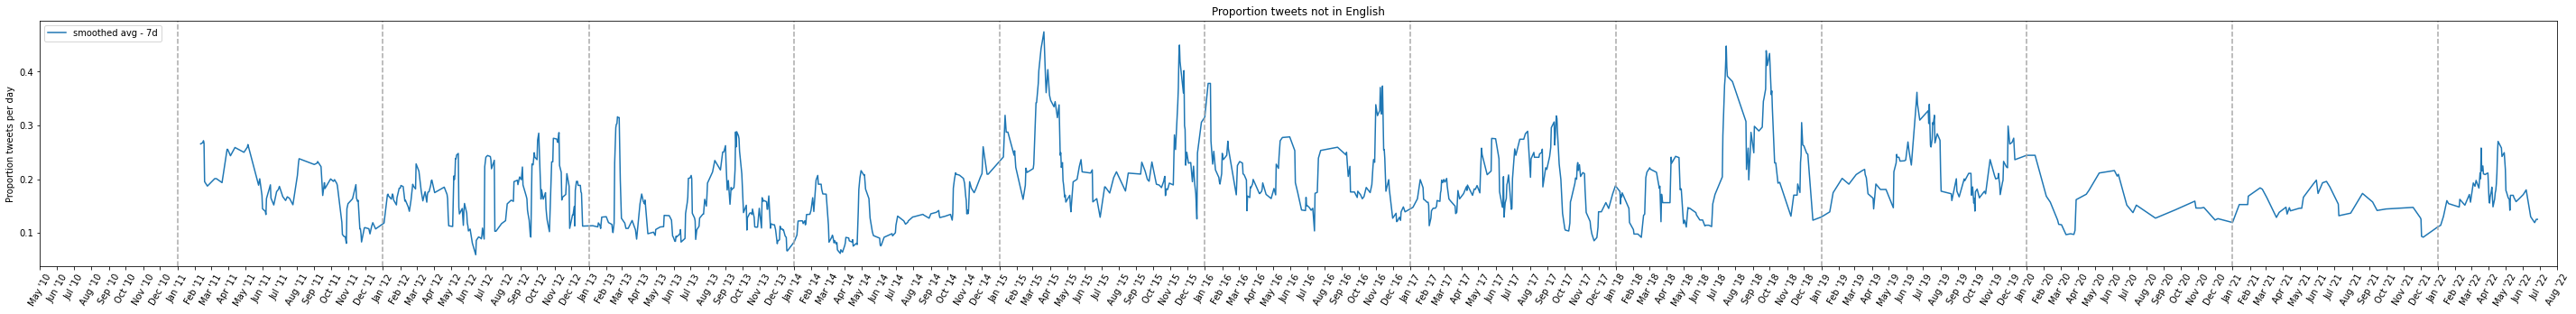

In [325]:
top_dict_other = plot_volume(language='other', freqs='D', plot_smooth_only=True, roll_window=7)

Removing tweets not in English, it's mostly translations of English tweets. We know that Twitter's automatic language detection is not great, so double-checking with langdetect and only including tweets tagged as English by both the default tagger and langdetect.

In [1523]:
df = df[(df['lang']=='en') & (df['lang_detected']=='en')]

Great, now let's fine tune some language models on these tweets for better performance (see pretrain script)

### Pretraining performance analysis

In [921]:
performances = pd.read_json('logs/pretraining/performances.jsonl', lines=True, orient='records')
performances['id'] = performances['name'].str.split('_').str[0]
performances['learning_rate'] = performances['name'].str.split('_').str[1].str.split('-').str[1].astype(float)
performances['batch_size'] = performances['name'].str.split('_').str[4].str.split('-').str[1].astype(int)
performances['warmup'] = performances['name'].str.split('_').str[5].str.split('-').str[1].astype(float)
performances['chunk_size'] = performances['name'].str.split('_').str[2].str.split('-').str[1].astype(float)

Let's first visualize the impact of learning rates.

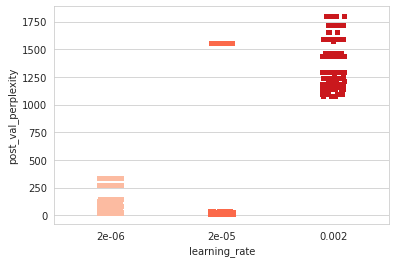

In [941]:
sns.stripplot(data=performances.sort_values(by='post_val_perplexity'), 
              x='learning_rate', y='post_val_perplexity', 
              palette='Reds', 
              marker='s')
plt.show()

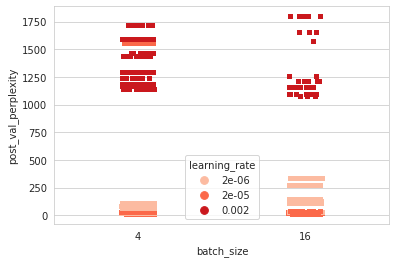

In [926]:
sns.stripplot(data=performances.sort_values(by='post_val_perplexity'), 
              x='batch_size', y='post_val_perplexity', 
              hue='learning_rate',
              marker='s', palette='Reds')
plt.show()

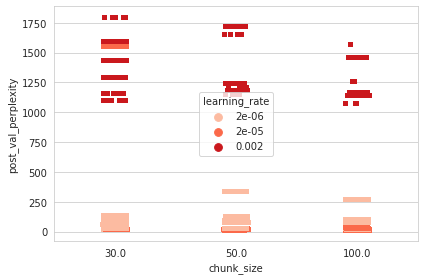

In [928]:
sns.stripplot(data=performances.sort_values(by='post_val_perplexity'), 
              x='chunk_size', y='post_val_perplexity', 
              hue='learning_rate',
              marker='s', palette='Reds')
plt.tight_layout()
plt.show()

Best learning rate seems to be univocally 2e-5, we'll go for batch_size=4 and chunk_size=100.

### Topic modeling preparation
Let's move on to modeling the topic of the tweets. We'll try to compare different modeling strategies, and both pretrained and fine-tuned models.
Then, we'll try to get an idea of what the evolution of topics has been over time. 
Let's start from comparing model metrics for multiple models, and parameter optimization configs.

#### Generate data

In [ ]:
first_contextualized_run = False

In [ ]:
if first_contextualized_run is True:
    topic_df = df[df['pretraining_splits']=='test'].sample(frac=1).reset_index()
    
    # Train test split
    import random
    random.seed(42)
    train_size = int(topic_df.shape[0] * .7)
    val_size = int(topic_df.shape[0] * .1)
    test_size = topic_df.shape[0] - train_size - val_size
    train_test = ['train'] * train_size + ['val'] * val_size + ['test'] * test_size
    random.shuffle(train_test)
    
    # Pretrained
    topic_df['topic_split'] = train_test 
    topic_df.to_json('processed/pre_topic_tweets.jsonl', lines=True, orient='records')

Training through `run_topics.py`

#### Model selection

In [1525]:
topic_perf = pd.read_json('logs/topic/performances.jsonl', 
                          orient='records', 
                          lines=True)

In [1092]:
def _preprocess_topic_performance(d):
    for k in ['vocab', 'bow', 'esize']:
        d[k] = d['name'].str.split(f'{k}-').str[1].str.split('_').str[0].astype(int)
    map_dict = {'comp': [8, 3],
                'lr': [11, 6],
                'batch': [10, 5]}
   
    def _get_name_substr(col, idx, n):
        return col.str.split('_').str[idx].str.lstrip(fr'{n}\-')
    
    def _match_finetuned_affix(col):
        return col.str.split('_').str[0].str.endswith(r'finetuned')
        
    def _make_col(n):
        return np.where(_match_finetuned_affix(d['name']), 
                        _get_name_substr(d['name'], map_dict[n][0], n),
                        _get_name_substr(d['name'], map_dict[n][1], n),).astype(float)
    
    d['components'] = _make_col('comp')
    d['lr_topic'] = _make_col('lr')
    d['batch_topic'] = _make_col('batch')
    d['lr_pretraining'] = np.where(_match_finetuned_affix(d['name']), 
                                   _get_name_substr(d['name'], 1, 'lr\-'),
                                   0).astype(float)
    d['unique_id'] = d['name'].str.split('_').str[0]
    for c in ['components', 'vocab', 'lr_topic', 'batch_topic']:
        d['unique_id'] = d['unique_id'] + f'_{c.split("_")[0]}-' + \
                         d[c].astype(str)
    d['unique_run'] = d['unique_id'] + '_run-' + d['run'].astype(str)    
    return d
    
    

In [1093]:
topic_perf = _preprocess_topic_performance(topic_perf)

Plot performances

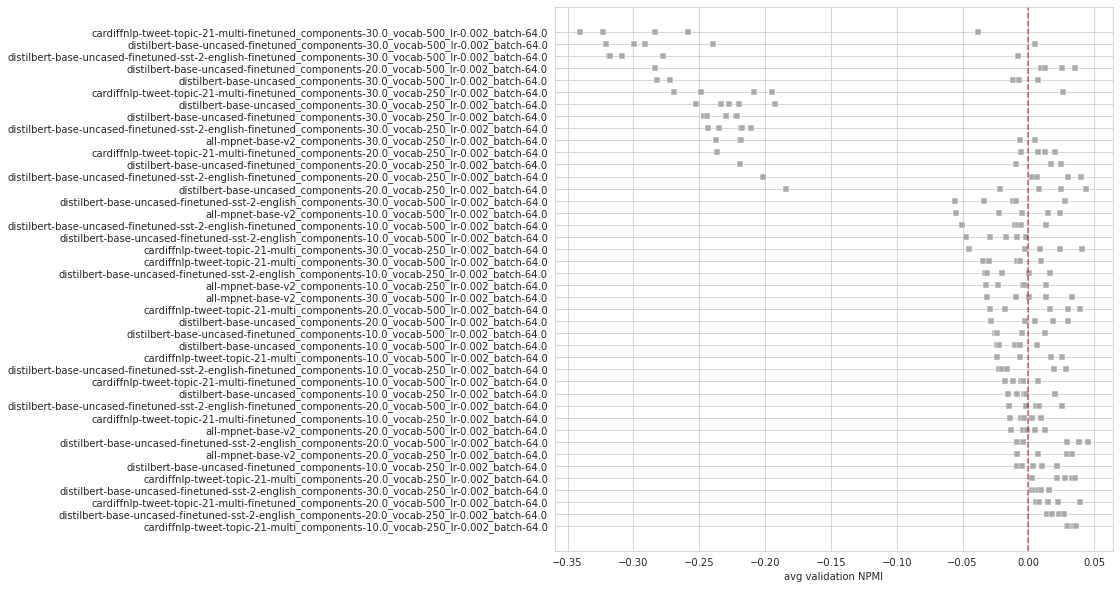

In [1094]:
sns.set_style('whitegrid')
plt.subplots(figsize=(10,10))
plt.axvline(0, linestyle='--', color='darkred', alpha=.6)
sns.scatterplot(data=topic_perf.sort_values(by='val_npmi_10'), 
                y='unique_id', x=f'val_npmi_10', color='darkgrey',
               marker='s')
plt.xlabel('avg validation NPMI')
plt.ylabel('')
plt.show()

Save best models

In [300]:
grouped = topic_perf.groupby('unique_id').mean().reset_index().sort_values(by='val_npmi_10')
grouped = grouped.merge(topic_perf[['unique_id', 'name']].drop_duplicates())
grouped['id'] = grouped['name'].str.split('_vocab').str[0]
grouped = grouped.sort_values(by='val_npmi_10').tail(n=20)
grouped = grouped[['id', 'vocab', 'bow', 'esize', 'components', 'lr_topic', 'batch_topic']]
grouped.to_json('logs/topic/best_models.jsonl', lines=True, orient='records')

Now fitting and saving these models through `fit_topic_final.py`

### Pick final model

In [1478]:
topic_perf = pd.read_json('logs/topic/performances_final.jsonl', 
                          orient='records', 
                          lines=True)

In [1479]:
topic_perf = _preprocess_topic_performance(topic_perf)

In [1480]:
topic_perf = topic_perf.sort_values(by='test_npmi_10', ascending=False).reset_index(drop=True)
topic_perf['top_npmi'] = (topic_perf.index < 5).astype(int)
topic_perf = topic_perf.sort_values(by='cwe_10', ascending=False).reset_index(drop=True)
topic_perf['top_cwe'] = (topic_perf.index < 5).astype(int)
topic_perf = topic_perf.sort_values(by='rbo_10', ascending=False).reset_index(drop=True)
topic_perf['top_rbo'] = (topic_perf.index < 5).astype(int)

<ipython-input-1482-225e86dfcd03>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_names = topic_perf.sort_values(by='test_npmi_10')[topic_perf['top_npmi']==1].unique_id.tolist()


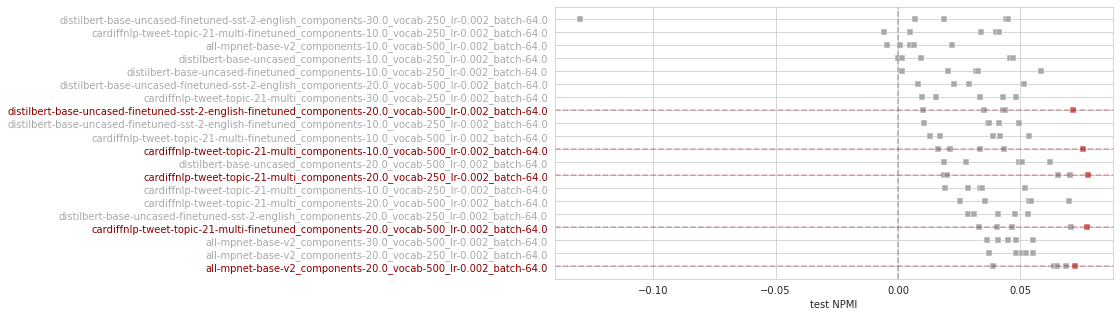

In [1482]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10,5))
plt.axvline(0, linestyle='--', color='darkgrey')
sns.scatterplot(data=topic_perf.sort_values(by='test_npmi_10'), 
                y='unique_id', x=f'test_npmi_10', 
                hue='top_npmi', legend=False, 
                palette=['darkgrey', 'indianred'],
                marker='s')
best_names = topic_perf.sort_values(by='test_npmi_10')[topic_perf['top_npmi']==1].unique_id.tolist()
label_cols = ["darkred" if model_n in best_names else 'darkgrey' 
              for model_n in topic_perf.sort_values(by='test_npmi_10')["unique_id"].unique()]
[t.set_color(label_cols[i]) for i, t in enumerate(ax.yaxis.get_ticklabels())]
for v in best_names:
    plt.axhline(v, color='darkred', linestyle='--', alpha=.3)
plt.xlabel('test NPMI')
plt.ylabel('')
plt.show()

<ipython-input-1483-1c81509c055a>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_names = topic_perf.sort_values(by='cwe_10')[topic_perf['top_cwe']==1].unique_id.tolist()


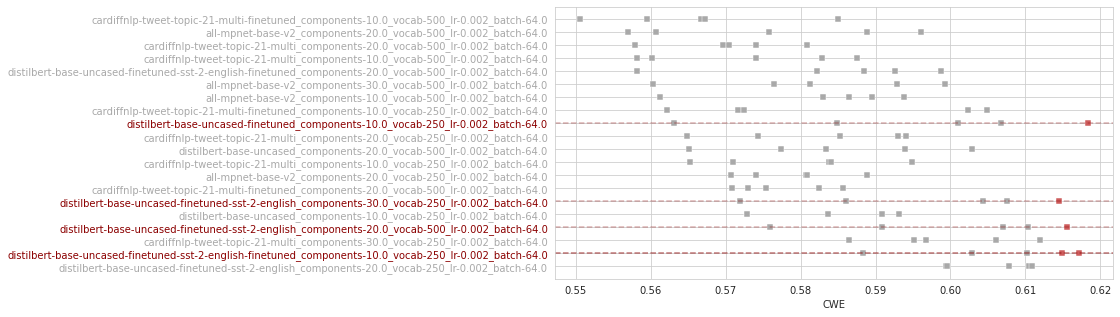

In [1483]:
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data=topic_perf.sort_values(by='cwe_10'), 
                y='unique_id', x=f'cwe_10', 
                hue='top_cwe', legend=False, 
                palette=['darkgrey', 'indianred'],
                marker='s')
best_names = topic_perf.sort_values(by='cwe_10')[topic_perf['top_cwe']==1].unique_id.tolist()
label_cols = ["darkred" if model_n in best_names else 'darkgrey' 
              for model_n in topic_perf.sort_values(by='cwe_10')["unique_id"].unique()]
[t.set_color(label_cols[i]) for i, t in enumerate(ax.yaxis.get_ticklabels())]
for v in best_names:
    plt.axhline(v, color='darkred', linestyle='--', alpha=.3)
plt.xlabel('CWE')
plt.ylabel('')
plt.show()

<ipython-input-1484-56c2106a8add>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_names = topic_perf.sort_values(by='rbo_10')[topic_perf['top_rbo']==1].unique_id.tolist()


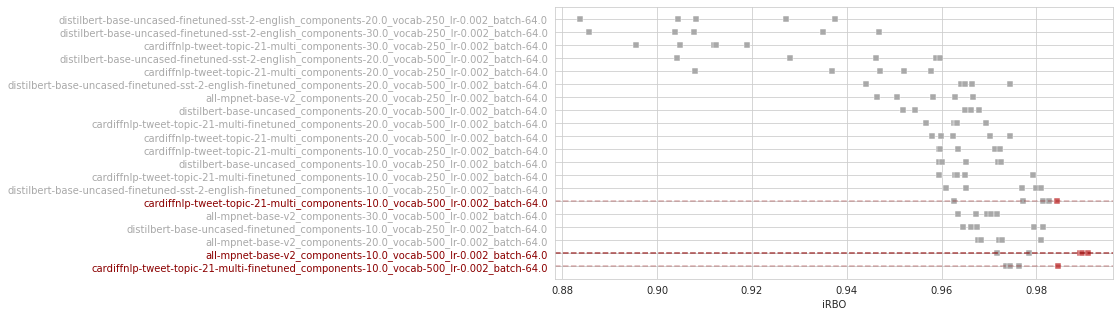

In [1484]:
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data=topic_perf.sort_values(by='rbo_10'), 
                y='unique_id', x=f'rbo_10', 
                hue='top_rbo', legend=False, 
                palette=['darkgrey', 'indianred'],
                marker='s')
best_names = topic_perf.sort_values(by='rbo_10')[topic_perf['top_rbo']==1].unique_id.tolist()
label_cols = ["darkred" if model_n in best_names else 'darkgrey' 
              for model_n in topic_perf.sort_values(by='rbo_10')["unique_id"].unique()]
[t.set_color(label_cols[i]) for i, t in enumerate(ax.yaxis.get_ticklabels())]
for v in best_names:
    plt.axhline(v, color='darkred', linestyle='--', alpha=.3)
plt.xlabel('iRBO')
plt.ylabel('')
plt.show()

### Analyze final model

#### Annotate topics

In [1485]:
top_npmi = list(zip(topic_perf[topic_perf['top_npmi']==1].sort_values(by='test_npmi_10', ascending=False).name.tolist(),
                    topic_perf[topic_perf['top_npmi']==1].sort_values(by='test_npmi_10', ascending=False).run.tolist()))

In [1528]:
top_map = {}
for t in top_npmi:
    topics = json.load(open(f'logs/topic/{t[0]}/topic_map_{t[1]}.json'))
    top_map[t[0]] = topics

Best model - CardiffNLP tweet topic model, 250-dim vocab, 20 topics.

In [1487]:
print(top_npmi[0][0])
for t in range(20):
    try:
        print(f'Topic {t}')
        print(top_map[top_npmi[0][0]][f'{t}'])
    except:
        break

cardiffnlp-tweet-topic-21-multi_vocab-250_bow-250_comp-20_esize-768_batch-64_lr-0.002_epochs-100_act-softplus
Topic 0
['live', 'conference', 'president', 'press', 'cet', 'junckereu', 'watch', 'amp', 'future', 'speech', 'vonderleyen', 'follow', 'join', 'today', 'timmermanseu', 'europe', 'debate', 'tomorrow', 'union', 'soteu']
Topic 1
['commission', 'amp', 'trade', 'statement', 'agreement', 'joint', 'states', 'member', 'eu', 'partnership', 'aid', 'barroso', 'following', 'state', 'cooperation', 'euro', 'economic', 'meeting', 'council', 'barrosoeu']
Topic 2
['european', 'union', 'today', 'day', 'soteu', 'junckereu', 'speech', 'first', 'europe', 'futureofeurope', 'years', 'year', 'world', 'vonderleyen', 'state', 'together', 'president', 'one', 'address', 'ahead']
Topic 3
['story', 'quoted', 'storify', 'euchat', 'cet', 'twitter', 'questions', 'follow', 'commissioner', 'live', 'summit', 'tomorrow', 'protection', 'watch', 'timmermanseu', 'en', 'join', 'business', 'data', 'rt']
Topic 4
['eu', '

In [1488]:
topic_20d = pd.read_json(f'logs/topic/{top_npmi[0][0]}/topic_preds_{top_npmi[0][1]}.jsonl',
                          orient='records', lines=True)

In [1489]:
t = 19
print(top_map[top_npmi[0][0]][f'{t}'])
print('\nTweets')
display(topic_20d.sort_values(by=f'topic_{t}', ascending=False).head(n=20).text.tolist())

['border', 'companies', 'market', 'report', 'justice', 'progress', 'euro', 'proposal', 'financial', 'business', 'area', 'ec', 'level', 'tax', 'common', 'good', 'strong', 'package', 'travel', 'may']

Tweets


['EC seeks criminal sanctions for insider dealing and market manipulation to improve deterrence and market integrity  ',
 'The proposal aims to modernise border controls, in order to:\n📦 facilitate trade\n🆗 improve safety and compliance checks\n📋 reduce the administrative burden for companies\nand more here ↓ #CustomsUnion ',
 'Our proposal sets out four key areas:\n\n🚧 Common criteria and thresholds for travel restrictions\n🚦 An agreed colour code\n❗ Common measures for travellers from high-risk areas\n✅ Clear and timely information to the public about any restrictions ',
 "#Environment: #EC proposes measures to tackle 'biopiracy' and facilitate nature-based #research ",
 'Key findings of the 2013 Progress Report on #Albania ',
 'Environment: #EC asks Ireland to recover costs of all water services  ',
 'A welcome step forward in our common efforts to strengthen the governance of the euro area. ',
 'Restoring confidence in financial statements: #EC aims at a higher quality, dynamic and

In [1490]:
topic_20comp = ['live_events', 
                'cooperation_announcements', 
                'state_of_the_eu', 
                'storify', 
                'consumer_rights_and_digital_policy', 
                'strategic_investment_funds',
                'humanitarian_support', 
                'press_conferences', 
                'institutional_events',
                'citizens_initiative', 
                'intra-eu_financial_support', 
                'health_and_covid_response',
                'research_and_innovation',
                'justice', 
                'post_summit_statements',
                'energy_and_sustainability', 
                'digitalization', 
                'public_engagement', 
                'climate_change', 
                'common_market_and_free_movement']
exclude_20 = ['live_events', 
              'cooperation_announcements',
              'press_conferences', 
              'institutional_events',
              'storify', 'post_summit_statements', 
              'state_of_the_eu', 
              'public_engagement',
              'common_market_and_free_movement'] 

Load annotated dataset

In [1491]:
for i in range(20):
    topic_20d.rename({f'topic_{i}': topic_20comp[i]}, axis=1, inplace=True)
topic_20d['top_topic'] = topic_20d[topic_20comp].apply(lambda x: topic_20comp[x.argmax()], 
                                                       axis=1)

In [1492]:
from scipy.stats import entropy
freq_dict = {'D': 'day', 'W': 'week', 'M': 'month', 'Y': 'year'}
figsizes = {'D': (50,5), 'W': (15,3), 'M': (10, 5), 'Y': (12,5)}
formats = {'D': '%Y-%m-%d', 'W': '%Y-%m-%d', 'M': '%Y-%m'}

def plot_topic_volume(topic_list, metric='prop', freqs='D', roll_window=7):
    top_dict = None
    for freq in [freqs]:
        figsize = figsizes[freq] if len(topic_list)<=1 else (30,5)
        fig, ax = plt.subplots(figsize=figsize)
        grouper = pd.Grouper(key='created_at', axis=0, freq=freq)
        if topic_20d['created_at'].dtype != 'datetime64':
            topic_20d['created_at'] = pd.to_datetime(topic_20d['created_at'], 
                                                     infer_datetime_format=True)
        if metric=='mean':
            grouped = topic_20d.drop_duplicates('text').groupby(grouper).mean().reset_index()
        else:
            grouped = topic_20d.drop_duplicates('text').groupby([grouper, 'top_topic']).count()
            grouped = grouped.reset_index()[['created_at', 
                                             'top_topic', 
                                             'index']].rename({'index': 'count'}, axis=1)
            top_per_unit = topic_20d.groupby(grouper).count()
            top_per_unit = top_per_unit.reset_index()[['created_at', 'index']].rename({'index': 'tot_count'},
                                                                                      axis=1)
            grouped = grouped.merge(top_per_unit)
            grouped['count'] = grouped['count'] / grouped['tot_count']
            if metric != 'entropy':
                grouped = grouped[['created_at', 
                                   'top_topic', 
                                   'count']].pivot(index='created_at', 
                                                   columns='top_topic', 
                                                   values='count').reset_index().fillna(0)
            else:
                grouped = grouped.groupby('created_at')['count'].agg(entropy).reset_index()
                grouped = grouped.rename({'count': 'entropy'}, axis=1)            
        if metric != 'entropy':    
            for t in topic_list:   
                if len(topic_list)<=1:
                    label=None
                    title=t
                else:
                    label=f'{t}'
                    title='Topic volume'
                grouped[f'{t}_smoothed'] = grouped[t].rolling(roll_window).mean()
                sns.lineplot(data=grouped, x='created_at', y=f'{t}_smoothed', 
                             label=label)
            plt.ylabel(f'Proportion tweets')
        else:
            grouped[f'entropy_smoothed'] = grouped['entropy'].rolling(roll_window).mean()
            sns.lineplot(data=grouped, x='created_at', y=f'entropy_smoothed', label=None)
            title='Entropy of topic distribution'
            top_dict = grouped[grouped['created_at'].apply(lambda x: x.year)>2011]
            top_dict = top_dict.sort_values(by='entropy').head(n=10).created_at.tolist()
        plt.xlabel('')
        plt.title(f'{title}')
        plt.xticks(rotation=60)
        # Make year boundaries
        for d in grouped.created_at.dt.year.unique()[1:]:
            plt.axvline(x=np.datetime64(f'{d}-01-01'), color='black', 
                                        linestyle='--', alpha=.3)
            plt.annotate(text=d, xy=(np.datetime64(f'{d}-06-01'), 120), color='black')
        if freq != 'Y':
            ax.xaxis.set_major_locator(md.MonthLocator((1,7)))
            ax.xaxis.set_major_formatter(md.DateFormatter('%b \'%y'))
        else:
            ax.xaxis.set_major_locator(md.YearLocator())
        plt.xlim(np.datetime64('2010-05-01'),np.datetime64('2022-08-01'))
        plt.savefig(f'figures/topic_volume.pdf')
        plt.show()
    return top_dict

Also create aggregate dataset with proportion of topics per 

In [1493]:
keeps = ['top_topic', 'text']
prop_topic = topic_20d.groupby('top_topic').agg(lambda x: x.count() / \
                                                topic_20d.shape[0]).reset_index()[keeps]
prop_topic['is_events'] = prop_topic['top_topic'].isin(exclude_20).astype(int)

#### Overall proportion of tweets per category

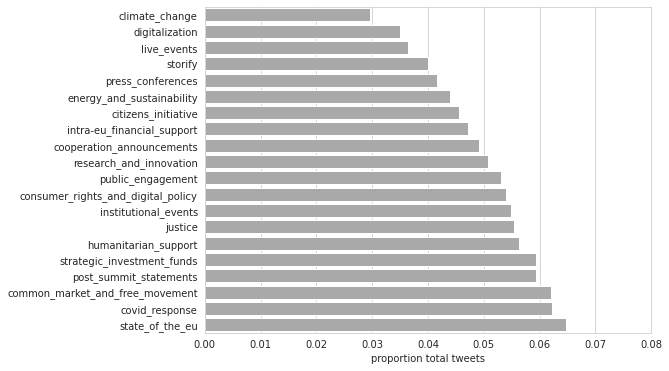

In [1494]:
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(data=prop_topic.sort_values(by='text'), 
            y='top_topic', x='text', color='darkgrey')
plt.xlabel('proportion total tweets')
plt.ylabel('')
plt.xlim(0,0.08)
plt.show()

### Topic volume over time

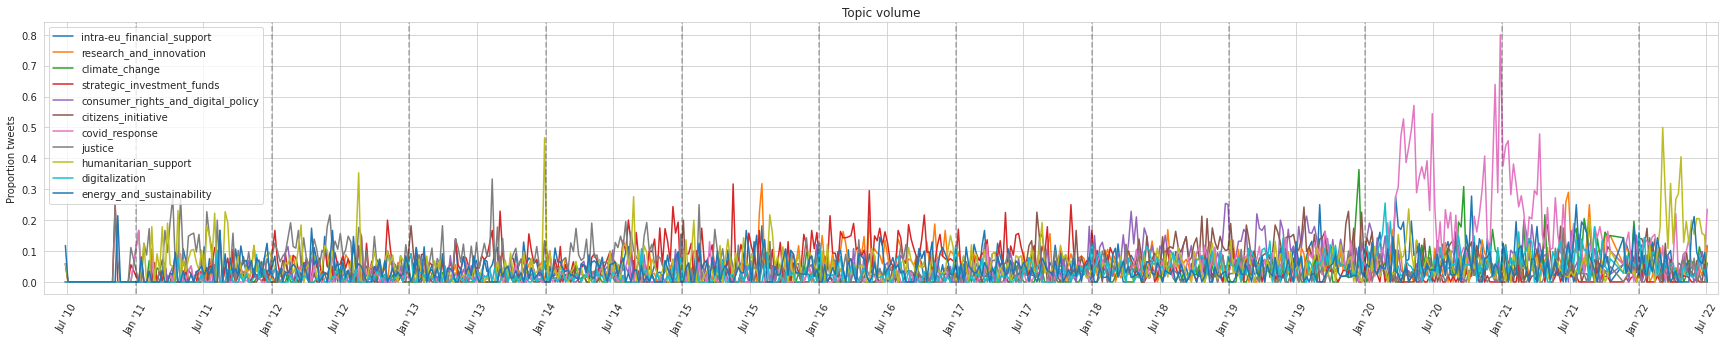

In [1495]:
plot_topic_volume(set(topic_20comp) - set(exclude_20), 
                  freqs='W', 
                  roll_window=1)
plt.show()

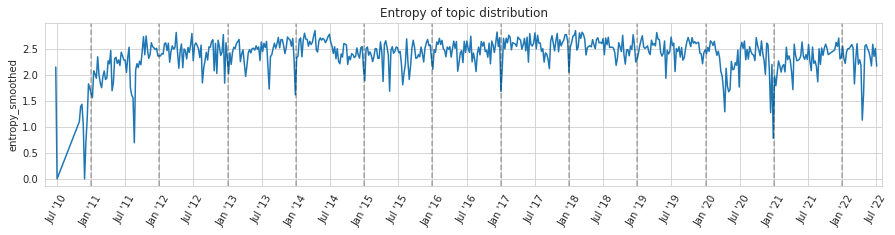

In [1496]:
low_ent = plot_topic_volume([], 
                            metric='entropy',
                            freqs='W', 
                            roll_window=1)
plt.show()

In [1497]:
for l in low_ent:
    print(l)
    display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &
                      ((topic_20d['created_at'] - l).apply(lambda x: x.days) >= 0)].mean(axis=0)[topic_20comp].sort_values(ascending=False))
    print('\n')
#for l in low_ent:
#    print(l)
#    display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &
#                      ((topic_20d['created_at'] - l).apply(lambda x: x.days) >= 0)].text.head(n=10).tolist())
#    print('\n')

2020-12-27 00:00:00


<ipython-input-1497-995b0570ee99>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &
<ipython-input-1497-995b0570ee99>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &


covid_response                        0.273061
climate_change                        0.072474
humanitarian_support                  0.067942
digitalization                        0.066687
energy_and_sustainability             0.064700
state_of_the_eu                       0.056897
citizens_initiative                   0.052110
research_and_innovation               0.044684
consumer_rights_and_digital_policy    0.037535
public_engagement                     0.034674
intra-eu_financial_support            0.033016
justice                               0.026003
live_events                           0.024868
institutional_events                  0.024661
cooperation_announcements             0.023839
strategic_investment_funds            0.022213
common_market_and_free_movement       0.021458
press_conferences                     0.019813
storify                               0.016784
post_summit_statements                0.016558
dtype: float64



2022-04-17 00:00:00


<ipython-input-1497-995b0570ee99>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &
<ipython-input-1497-995b0570ee99>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &


humanitarian_support                  0.224883
justice                               0.135053
consumer_rights_and_digital_policy    0.104610
intra-eu_financial_support            0.088185
covid_response                        0.071575
citizens_initiative                   0.041888
research_and_innovation               0.039453
digitalization                        0.034275
climate_change                        0.027963
press_conferences                     0.027795
institutional_events                  0.025857
public_engagement                     0.024690
post_summit_statements                0.023890
strategic_investment_funds            0.021988
storify                               0.020417
common_market_and_free_movement       0.019943
energy_and_sustainability             0.018785
state_of_the_eu                       0.018697
live_events                           0.017345
cooperation_announcements             0.012730
dtype: float64



2020-12-13 00:00:00


<ipython-input-1497-995b0570ee99>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &
<ipython-input-1497-995b0570ee99>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &


covid_response                        0.268266
consumer_rights_and_digital_policy    0.097695
digitalization                        0.082354
intra-eu_financial_support            0.079837
climate_change                        0.052822
humanitarian_support                  0.050968
energy_and_sustainability             0.044573
public_engagement                     0.041437
research_and_innovation               0.039383
justice                               0.031098
state_of_the_eu                       0.030849
common_market_and_free_movement       0.026663
citizens_initiative                   0.024902
live_events                           0.024205
post_summit_statements                0.023188
press_conferences                     0.021893
storify                               0.020585
institutional_events                  0.013729
cooperation_announcements             0.013010
strategic_investment_funds            0.012561
dtype: float64



2020-04-12 00:00:00


<ipython-input-1497-995b0570ee99>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &
<ipython-input-1497-995b0570ee99>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &


covid_response                        0.232503
humanitarian_support                  0.091468
intra-eu_financial_support            0.085947
consumer_rights_and_digital_policy    0.060545
digitalization                        0.057584
climate_change                        0.048789
research_and_innovation               0.044061
citizens_initiative                   0.043305
live_events                           0.040024
state_of_the_eu                       0.037905
post_summit_statements                0.034505
justice                               0.033492
press_conferences                     0.031661
energy_and_sustainability             0.030937
public_engagement                     0.028345
institutional_events                  0.024689
strategic_investment_funds            0.023789
common_market_and_free_movement       0.018576
storify                               0.015968
cooperation_announcements             0.015889
dtype: float64



2013-12-29 00:00:00


<ipython-input-1497-995b0570ee99>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &
<ipython-input-1497-995b0570ee99>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &


storify                               0.117539
strategic_investment_funds            0.073578
public_engagement                     0.069472
live_events                           0.065950
justice                               0.059678
institutional_events                  0.057944
press_conferences                     0.055556
research_and_innovation               0.055167
post_summit_statements                0.052428
common_market_and_free_movement       0.047044
cooperation_announcements             0.046528
state_of_the_eu                       0.045817
humanitarian_support                  0.045217
consumer_rights_and_digital_policy    0.038489
citizens_initiative                   0.036817
covid_response                        0.035172
intra-eu_financial_support            0.027367
digitalization                        0.026667
climate_change                        0.023022
energy_and_sustainability             0.020572
dtype: float64



2022-04-24 00:00:00


<ipython-input-1497-995b0570ee99>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &
<ipython-input-1497-995b0570ee99>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &


humanitarian_support                  0.116894
covid_response                        0.100413
justice                               0.099561
consumer_rights_and_digital_policy    0.073052
intra-eu_financial_support            0.054489
citizens_initiative                   0.054322
live_events                           0.051465
institutional_events                  0.051263
state_of_the_eu                       0.044478
digitalization                        0.043965
post_summit_statements                0.041867
press_conferences                     0.037117
public_engagement                     0.036687
climate_change                        0.036285
storify                               0.030206
energy_and_sustainability             0.028920
cooperation_announcements             0.027557
common_market_and_free_movement       0.027146
strategic_investment_funds            0.023296
research_and_innovation               0.020987
dtype: float64



2020-05-03 00:00:00


<ipython-input-1497-995b0570ee99>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &
<ipython-input-1497-995b0570ee99>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &


covid_response                        0.298238
intra-eu_financial_support            0.077081
humanitarian_support                  0.071948
state_of_the_eu                       0.060234
digitalization                        0.058515
climate_change                        0.040025
public_engagement                     0.037264
consumer_rights_and_digital_policy    0.033525
press_conferences                     0.033495
citizens_initiative                   0.033175
live_events                           0.030530
justice                               0.030119
research_and_innovation               0.029066
energy_and_sustainability             0.028901
storify                               0.027334
institutional_events                  0.026085
common_market_and_free_movement       0.025956
strategic_investment_funds            0.020801
post_summit_statements                0.020129
cooperation_announcements             0.017601
dtype: float64



2017-01-01 00:00:00


<ipython-input-1497-995b0570ee99>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &
<ipython-input-1497-995b0570ee99>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &


strategic_investment_funds            0.195741
research_and_innovation               0.121618
public_engagement                     0.080413
intra-eu_financial_support            0.050156
common_market_and_free_movement       0.048944
state_of_the_eu                       0.044282
consumer_rights_and_digital_policy    0.043174
citizens_initiative                   0.042777
cooperation_announcements             0.041462
institutional_events                  0.039351
digitalization                        0.038200
energy_and_sustainability             0.037054
storify                               0.034938
justice                               0.034228
humanitarian_support                  0.030310
post_summit_statements                0.027364
covid_response                        0.023033
press_conferences                     0.022908
live_events                           0.022787
climate_change                        0.021236
dtype: float64



2015-05-17 00:00:00


<ipython-input-1497-995b0570ee99>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &
<ipython-input-1497-995b0570ee99>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &


live_events                           0.098510
press_conferences                     0.091855
storify                               0.082117
strategic_investment_funds            0.062714
post_summit_statements                0.060890
institutional_events                  0.058512
cooperation_announcements             0.058055
humanitarian_support                  0.056410
common_market_and_free_movement       0.056188
state_of_the_eu                       0.043781
justice                               0.043067
intra-eu_financial_support            0.042845
covid_response                        0.036745
public_engagement                     0.036150
research_and_innovation               0.034617
energy_and_sustainability             0.031762
consumer_rights_and_digital_policy    0.027717
citizens_initiative                   0.027233
climate_change                        0.026871
digitalization                        0.023940
dtype: float64



2020-04-05 00:00:00


<ipython-input-1497-995b0570ee99>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &
<ipython-input-1497-995b0570ee99>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &


covid_response                        0.266932
intra-eu_financial_support            0.166666
humanitarian_support                  0.105316
justice                               0.051403
digitalization                        0.047700
consumer_rights_and_digital_policy    0.047621
research_and_innovation               0.033276
citizens_initiative                   0.032579
state_of_the_eu                       0.029171
energy_and_sustainability             0.023592
institutional_events                  0.023471
press_conferences                     0.022853
public_engagement                     0.022297
climate_change                        0.021571
cooperation_announcements             0.018082
storify                               0.018011
strategic_investment_funds            0.017968
common_market_and_free_movement       0.017674
live_events                           0.017395
post_summit_statements                0.016397
dtype: float64

In [1498]:
for l in low_ent:
    print(l)
    display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &
                      ((topic_20d['created_at'] - l).apply(lambda x: x.days) >= 0)].groupby('top_topic').count()[['text']].sort_values(by='text', ascending=False))
    print('\n')

2020-12-27 00:00:00


,text
top_topic,
covid_response,14
energy_and_sustainability,4
climate_change,3
digitalization,2
humanitarian_support,2
citizens_initiative,1
common_market_and_free_movement,1
consumer_rights_and_digital_policy,1
cooperation_announcements,1




2022-04-17 00:00:00


,text
top_topic,
humanitarian_support,17
justice,9
consumer_rights_and_digital_policy,5
climate_change,2
citizens_initiative,1
common_market_and_free_movement,1
intra-eu_financial_support,1
press_conferences,1
research_and_innovation,1




2020-12-13 00:00:00


,text
top_topic,
covid_response,20
climate_change,3
consumer_rights_and_digital_policy,3
digitalization,3
energy_and_sustainability,2
humanitarian_support,2
intra-eu_financial_support,2
research_and_innovation,2
citizens_initiative,1




2020-04-12 00:00:00


,text
top_topic,
covid_response,14
humanitarian_support,4
citizens_initiative,3
intra-eu_financial_support,3
climate_change,2
digitalization,2
energy_and_sustainability,2
research_and_innovation,2
consumer_rights_and_digital_policy,1




2013-12-29 00:00:00


,text
top_topic,
storify,4
common_market_and_free_movement,2
justice,2
public_engagement,2
state_of_the_eu,2
consumer_rights_and_digital_policy,1
institutional_events,1
live_events,1
post_summit_statements,1




2022-04-24 00:00:00


,text
top_topic,
humanitarian_support,11
justice,11
consumer_rights_and_digital_policy,5
covid_response,5
citizens_initiative,4
digitalization,3
post_summit_statements,3
institutional_events,2
intra-eu_financial_support,2




2020-05-03 00:00:00


,text
top_topic,
covid_response,41
intra-eu_financial_support,6
state_of_the_eu,4
climate_change,3
humanitarian_support,3
common_market_and_free_movement,2
consumer_rights_and_digital_policy,2
digitalization,2
energy_and_sustainability,2




2017-01-01 00:00:00


,text
top_topic,
strategic_investment_funds,15
public_engagement,7
research_and_innovation,4
state_of_the_eu,4
common_market_and_free_movement,2
consumer_rights_and_digital_policy,2
citizens_initiative,1
digitalization,1
humanitarian_support,1




2015-05-17 00:00:00


,text
top_topic,
storify,6
common_market_and_free_movement,5
live_events,5
press_conferences,5
humanitarian_support,4
institutional_events,3
state_of_the_eu,3
cooperation_announcements,2
intra-eu_financial_support,2




2020-04-05 00:00:00


,text
top_topic,
covid_response,23
intra-eu_financial_support,8
humanitarian_support,3
consumer_rights_and_digital_policy,1
digitalization,1
energy_and_sustainability,1
justice,1


Low-entropy weeks are associated to crisis moments (mainly COVID, Ukrainian crisis)

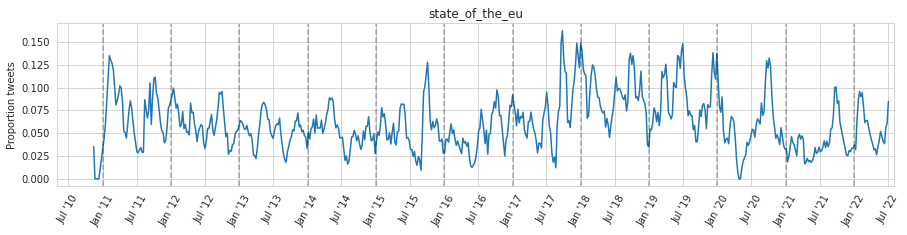

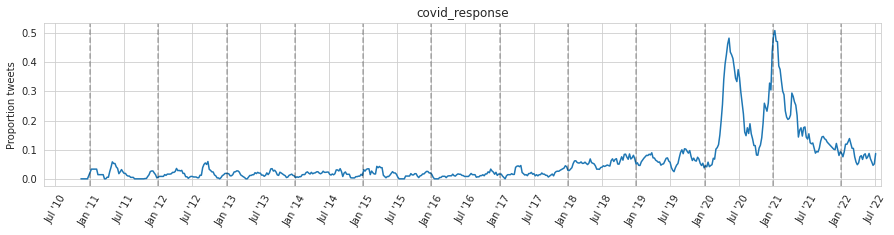

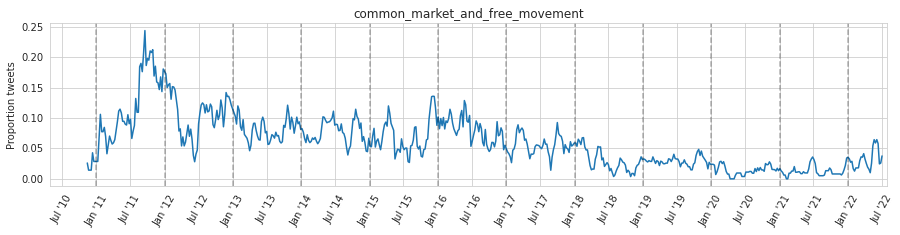

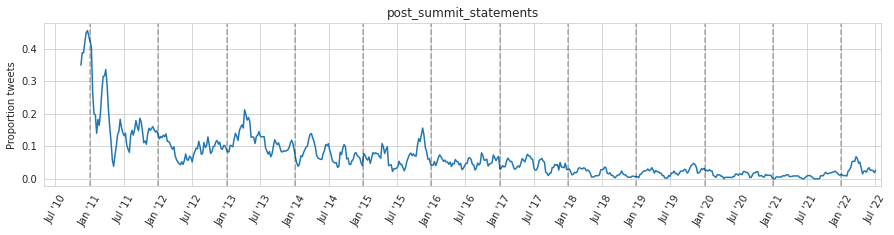

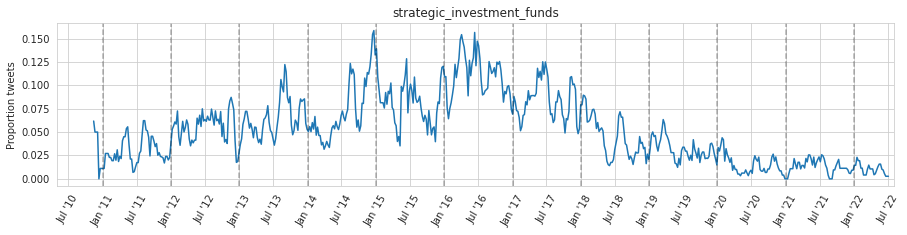

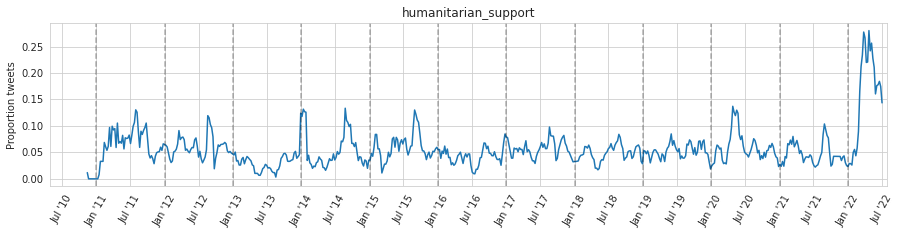

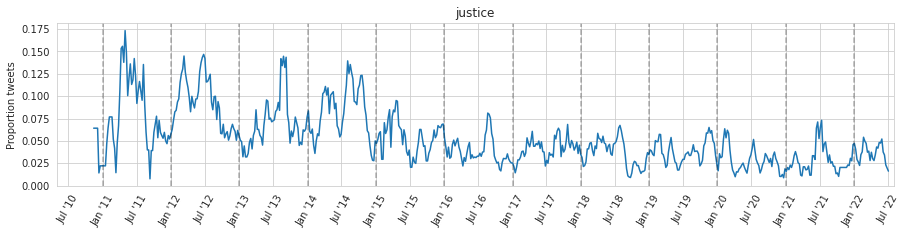

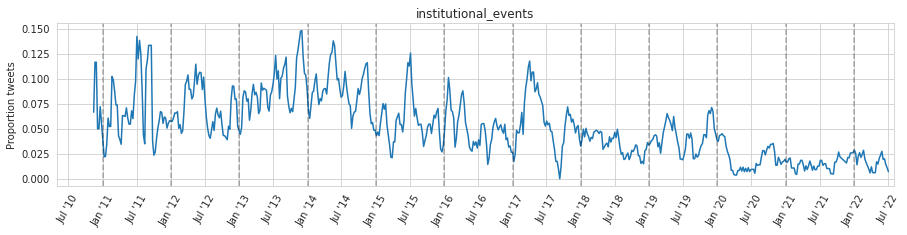

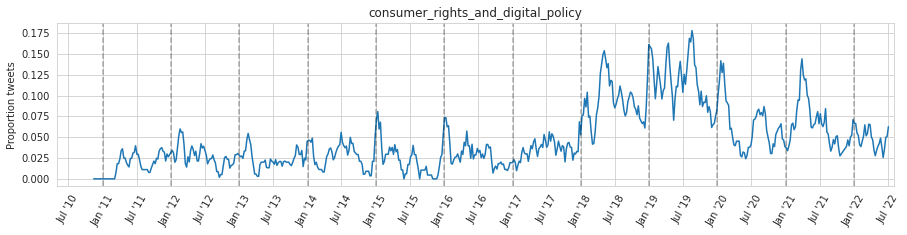

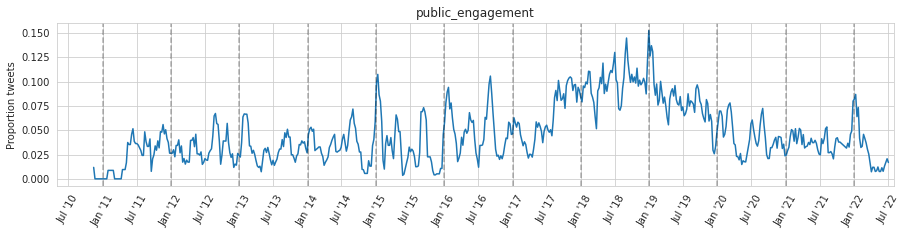

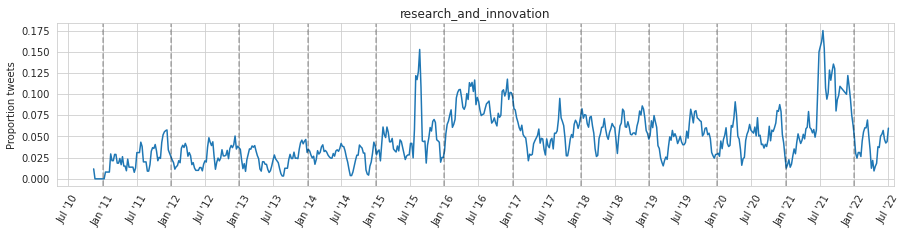

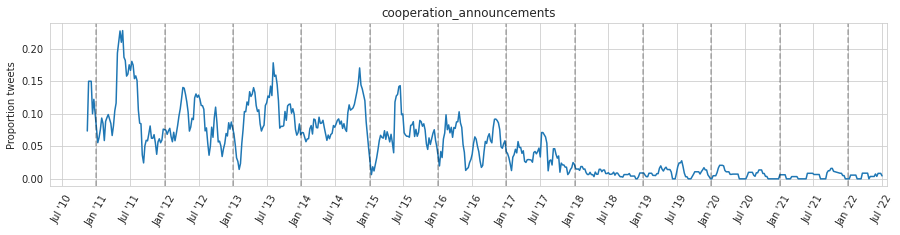

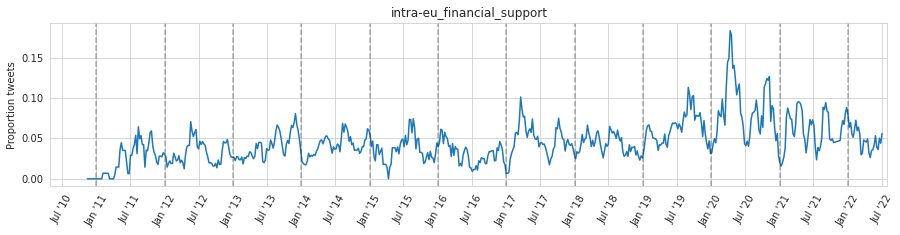

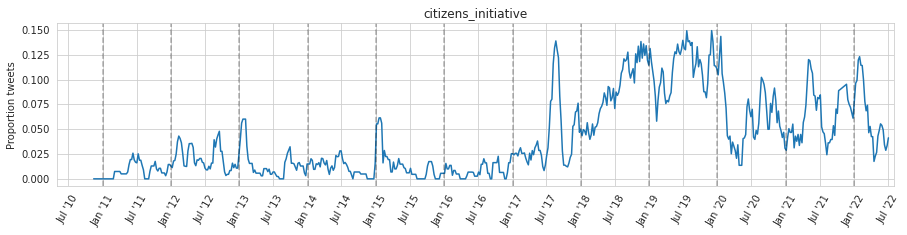

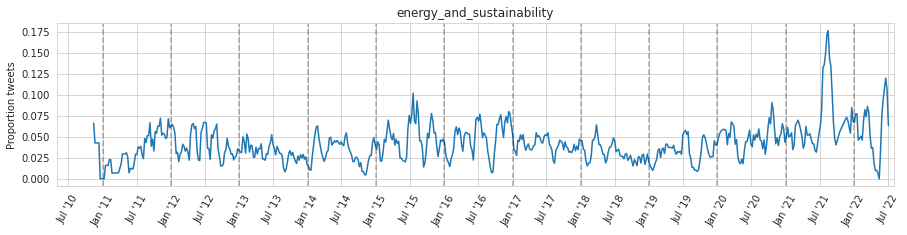

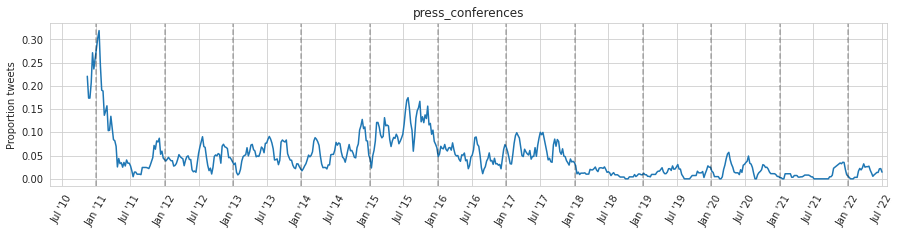

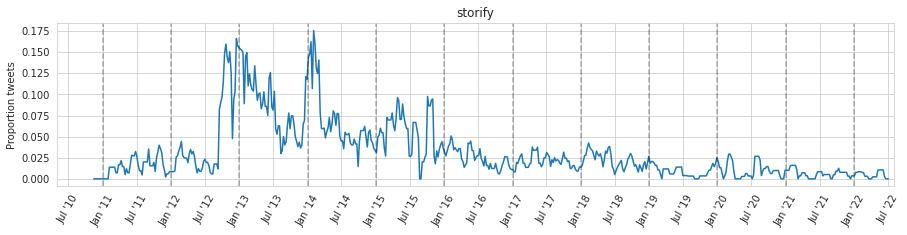

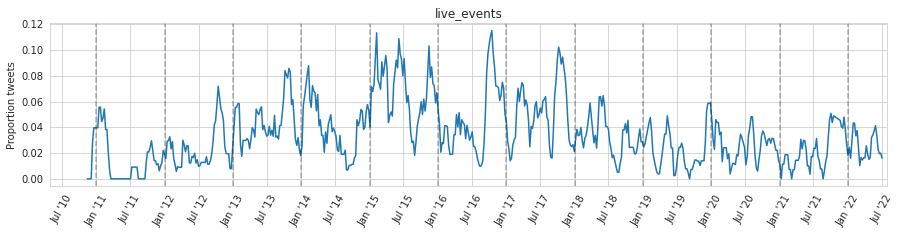

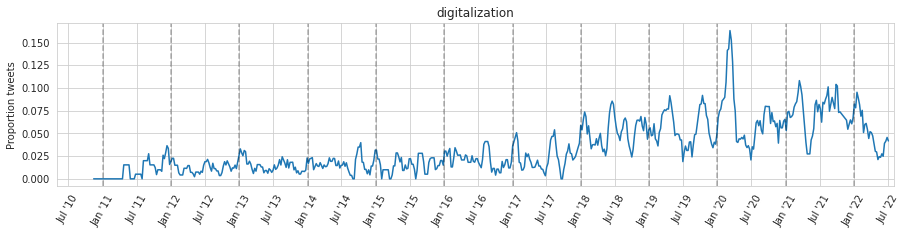

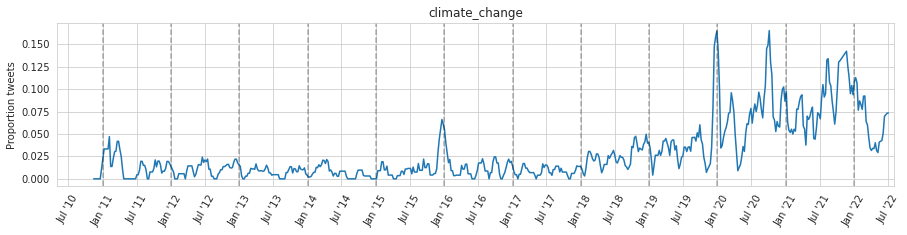

In [1499]:
for t in prop_topic.sort_values(by='text', ascending=False).top_topic.tolist():
    plot_topic_volume([t], 
                      freqs='W', 
                      roll_window=5)
    plt.show()

### Engagement as a function of topic

In [1501]:
aggs = topic_20d.groupby('top_topic')[['like_count', 
                                       'retweet_count', 
                                       'reply_count', 
                                       'quote_count']].agg('mean').reset_index()
aggs.columns = ['variable', 'mean_like', 'mean_rt', 'mean_reply', 'mean_quote']
top_likes = aggs.sort_values(by='mean_like').variable.tolist()
top_rts = aggs.sort_values(by='mean_rt').variable.tolist()
top_reply = aggs.sort_values(by='mean_reply').variable.tolist()
top_quote = aggs.sort_values(by='mean_quote').variable.tolist()

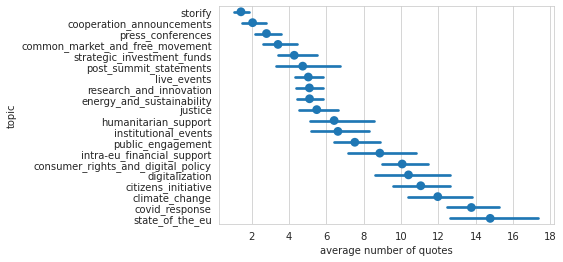

In [1502]:
sns.pointplot(data=topic_20d,
               x='quote_count', y='top_topic',
              errorbar='sd', join=False,
              order = top_quote)
plt.xlabel('average number of quotes')
plt.ylabel('topic')
plt.show()

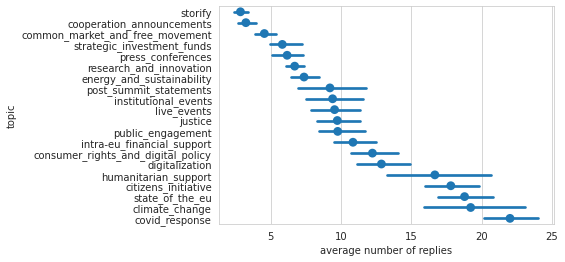

In [1503]:
sns.pointplot(data=topic_20d,
               x='reply_count', y='top_topic',
              errorbar='sd', join=False,
              order = top_reply,)
plt.xlabel('average number of replies')
plt.ylabel('topic')
plt.show()

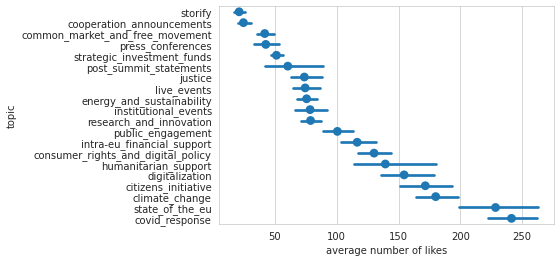

In [1504]:
sns.pointplot(data=topic_20d, 
               x='like_count', y='top_topic',
              errorbar='sd', join=False,
              order = top_likes)
plt.xlabel('average number of likes')
plt.ylabel('topic')
plt.show()

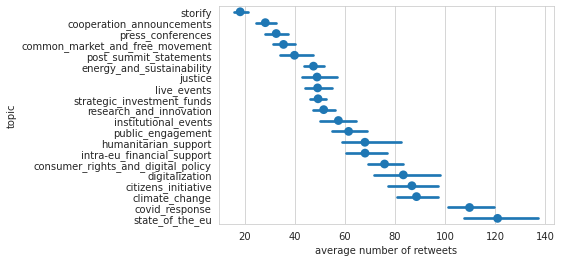

In [1505]:
sns.pointplot(data=topic_20d, 
               x='retweet_count', y='top_topic',
              errorbar='sd', join=False,
              order = top_rts)
plt.xlabel('average number of retweets')
plt.ylabel('topic')
plt.show()

In [1534]:
# End

#### Emotions analysis

In [ ]:
# TODO

#### Simpler models

In [ ]:
# TODO

### Next steps
- Try simpler model with tweetopic
- Emotion analysis
- Move performance backup to archive

Other:
- Emotions of response as a function of topics